In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import string

import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfTransformer 
from sklearn.cluster import KMeans,DBSCAN,Birch,MeanShift
from sklearn import metrics

In [2]:
data = pd.read_json('chislab.json',orient="split")
print(data.shape)
print(data.columns)

(157110, 17)
Index(['Accept', 'Accept-Charset', 'Accept-Encoding', 'Accept-Language',
       'Cache-control', 'Connection', 'Content-Length', 'Content-Type',
       'Cookie', 'Host', 'Pragma', 'User-Agent', 'X-Real-IP', 'argument',
       'http', 'method', 'url'],
      dtype='object')


In [3]:
###  删除重复的样本 ####
url = pd.DataFrame()
url['url'] = data['url'].drop_duplicates().values

###
a = url['url'].str.slice(1).str.split('/')
url_str = a.map(lambda x: ' '.join(x)).str.lower()
print(url_str.shape)
url_str.head()

(1819,)


0                synchrony-proxy v1 bayeux-sync1
1             json startheartbeatactivity.action
2                rest analytics 1.0 publish bulk
3           attach page-icon(11-13-13-23-05).png
4    attach footer-desktop-l(11-13-13-23-05).png
Name: url, dtype: object

In [4]:
##### TF-IDF 分词 #####
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(url_str) 
print(tfidf_matrix[0])

url_array = tfidf_matrix.toarray()
print(url_array.shape)

  (0, 1120)	0.28662083878291805
  (0, 1025)	0.28785595475065107
  (0, 1178)	0.28974588338249385
  (0, 564)	0.6127947320077359
  (0, 1119)	0.6127947320077359
(1819, 1225)


In [5]:
######   K-means调参 ######
def easy_get_parameter_k_means(data):
    test_scores =[]
    n_clusters_end =10
    n_clusters_start =2
    while n_clusters_start <=n_clusters_end:
        print(n_clusters_start)
        km = KMeans(n_clusters=n_clusters_start)
        km.fit(data)
        clusters = km.labels_.tolist()
        #score = metrics.silhouette_score(X=data,labels=clusters)
        score = metrics.calinski_harabaz_score(X=data,labels=clusters)
        num = sorted([(np.sum([1 for a in clusters if a==i]),i) for i in set(clusters)])[-1]
        test_scores.append([n_clusters_start,score,num[0],num[1]])
        n_clusters_start += 1
    return pd.DataFrame(test_scores,columns=['共分了几类','分数','最大类包含的个数','聚类的名称']).sort_values(by ='分数',ascending =False)

In [6]:
easy_get_parameter_k_means(url_array) #得到最佳参数

2
3
4
5
6
7
8
9
10


,共分了几类,分数,最大类包含的个数,聚类的名称
2,4,100.698917,770,1
3,5,93.568126,676,0
0,2,92.737390,1475,0
1,3,89.866214,891,1
4,6,84.920919,577,0
5,7,77.090274,617,5
6,8,73.849672,414,7
7,9,72.215379,605,2
8,10,70.242313,419,6


In [24]:
##### K-means #####
cls_num = 4
clf = KMeans(n_clusters=cls_num)
#clf = DBSCAN()
#clf = MeanShift()
s = clf.fit(url_array)  

centers = clf.cluster_centers_  ## 类的中心坐标，关于词袋特征的
url['class'] = clf.labels_     ## 每个样本所属的类

k: Synchrony, True, State, Data, 41E274A915F4, 4Da6Be73, D29F, 3Daa, Rewrite, 846D, V1, Request, Proxy, At, Head, Cached, Type, Tagged, Format, Confluence
 
r: Rest, Likes, Content, Watchstate, Button, Watch, Latest, Action, Files, Quickreload, Json, Attachments, E5, Labels, Api, Ui, Conversion, Documentconversion, Tinymce, Thumbnail
 
b: 11, Attach, Png, Footer, 19, 17, 16, 13, 37, Desktop, Lo, 15, Mobile, 54, 12, Icon, Page, 10, Co, 26
 
m: Confluence, Resources, C32F84C806260A834C2E109E904A2D8Ee4F8E175, 7702, Download, Zh_Cn, Icons, Js, Css, Atlassian, Batch, Com, Cdn, Images, Contextbatch, _Super, Atl, Plugins, Svg, En_Us
 


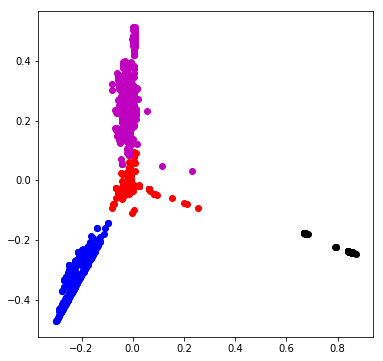

In [25]:
color = ['k', 'r', 'b', 'm', 'g', 'y', 'c']   
####  统计每一类排名前n的关键词 #####
top = pd.DataFrame(centers.T)
top['Name'] = tfidf_vectorizer.get_feature_names()

for i in range(cls_num):
    top_1 = top.sort_values(i,ascending=False).iloc[:20, :]
    a = ', '.join(top_1['Name']).title()
    print(str(color[i])+": "+str(a))
    print(' ')

####  利用PCA绘制图 #####

from sklearn.decomposition import PCA
pca = PCA(n_components=2)             #输出两维
newData = pca.fit_transform(url_array) #载入N维
url['PCA1'] = newData[:,0]
url['PCA2'] = newData[:,1]



fig = plt.figure(figsize=(6,6))

# 黑1 红2 蓝3 粉4 绿5 黄6 
for _ in range(cls_num):
    plt.scatter(url[url['class']==_]["PCA1"], url[url['class']==_]["PCA2"], color=color[_]) 

In [14]:
#### 运行一次就行 #####
from sklearn.manifold import TSNE
tsne = TSNE()
tsne.fit_transform(url_array)
tsne = pd.DataFrame(tsne.embedding_)

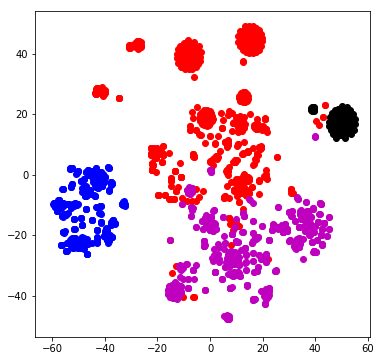

In [26]:
#### TSNE绘图 ####
fig = plt.figure(figsize=(6,6))

color = ['k', 'r', 'b', 'm', 'g', 'y', 'c']
# 黑1 红2 蓝3 粉4 绿5 黄6 
for _ in range(cls_num):
    plt.scatter(tsne[url['class']==_][0], tsne[url['class']==_][1], color=color[_]) 

In [41]:
dict_v = tfidf_vectorizer.vocabulary_
a = sorted(dict_v.items(),key = lambda x:x[1],reverse = True)
a[:15]

[('zqq', 1224),
 ('zip', 1223),
 ('zh_cn', 1222),
 ('zg', 1221),
 ('zfj', 1220),
 ('zd', 1219),
 ('yy', 1218),
 ('ygd', 1217),
 ('xoauth_requestor_id', 1216),
 ('xls', 1215),
 ('worker', 1214),
 ('worked', 1213),
 ('woff', 1212),
 ('wink', 1211),
 ('wikixhtmlconverter', 1210)]

In [38]:
dict_v

{'synchrony': 1120,
 'proxy': 1025,
 'v1': 1178,
 'bayeux': 564,
 'sync1': 1119,
 'json': 890,
 'startheartbeatactivity': 1103,
 'action': 469,
 'rest': 1047,
 'analytics': 493,
 'publish': 1026,
 'bulk': 597,
 'attach': 510,
 'page': 982,
 'icon': 860,
 '11': 25,
 '13': 28,
 '23': 69,
 '05': 11,
 'png': 1006,
 'footer': 816,
 'desktop': 703,
 'mobile': 944,
 'lo': 908,
 'avatar_80747d194': 531,
 '57': 193,
 '49': 169,
 'avatar_60f0e4909': 529,
 'jpg': 887,
 'blogpost': 581,
 'quickreload': 1031,
 'latest': 898,
 'capabilities': 622,
 '9634218': 360,
 'data': 690,
 '4da6be73': 176,
 'd29f': 679,
 '3daa': 139,
 '846d': 271,
 '41e274a915f4': 146,
 'confluence': 658,
 'state': 1104,
 'at': 506,
 'head': 838,
 'format': 820,
 'type': 1163,
 'tagged': 1124,
 'rewrite': 1053,
 'request': 1042,
 'true': 1160,
 'cached': 611,
 'false': 796,
 'tinymce': 1143,
 'content': 660,
 'optimistic': 978,
 'jiraanywhere': 886,
 'servers': 1065,
 'emoticons': 775,
 'autoconvert': 522,
 'shortcutlinkconfig